In [1]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import norm

import warnings
warnings.filterwarnings(action='once')
import tensorflow as tf

/home/kmoulton/.local/share/virtualenvs/ai_tools-Uu8yhF81/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kmoulton/.local/share/virtualenvs/ai_tools-Uu8yhF81/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/kmoulton/.local/share/virtualenvs/ai_tools-Uu8yhF81/lib64/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/kmoulton/.local/share/virtualenvs/ai_tools-Uu8yhF81/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:5605: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/kmoulton

In [2]:
print("GPU Available: ", tf.test.is_gpu_available())
print("Eager execution enabled: ", tf.executing_eagerly())

GPU Available:  False
Eager execution enabled:  True


# Load and rescale data

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

scale = tf.constant(255, dtype=tf.dtypes.float32)
x_train, x_test = train_images/scale, test_images/scale
y_train, y_test = tf.expand_dims(train_labels, 1), tf.expand_dims(test_labels, 1)

#mean = tf.math.reduce_mean(x_train)
#std = tf.math.reduce_std(x_train)
#x_train, x_test = (x_train-mean)/std, (x_test-mean)/std

# Define, compile, and train model

In [4]:
from tensorflow import keras

# single dense layer, i.e. multiple logistic regression
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation='softmax')
])

training_params = {'optimizer': 'adam',
                   'loss': 'sparse_categorical_crossentropy',
                   'metrics': ['accuracy']}

tf.random.set_seed(123)
np.random.seed(123)
model.compile(**training_params)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [5]:
# run the training
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

W0911 08:52:46.042210 140588708734784 deprecation.py:323] From /home/kmoulton/.local/share/virtualenvs/ai_tools-Uu8yhF81/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.4653 - accuracy: 0.8788 - val_loss: 0.3067 - val_accuracy: 0.9154
Epoch 2/10
60000/60000 [==============================] - 3s 48us/sample - loss: 0.3033 - accuracy: 0.9152 - val_loss: 0.2821 - val_accuracy: 0.9205
Epoch 3/10
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2829 - accuracy: 0.9211 - val_loss: 0.2767 - val_accuracy: 0.9233
Epoch 4/10
60000/60000 [==============================] - 3s 47us/sample - loss: 0.2733 - accuracy: 0.9242 - val_loss: 0.2668 - val_accuracy: 0.9266
Epoch 5/10
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2667 - accuracy: 0.9254 - val_loss: 0.2663 - val_accuracy: 0.9258
Epoch 6/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2616 - accuracy: 0.9278 - val_loss: 0.2741 - val_accuracy: 0.9225
Epoch 7/10
60000/60000 [==============================] 

# Convert to TFLite and save to disk

In [6]:
models_dir = pathlib.Path("./mnist_models/")
models_dir.mkdir(exist_ok=True, parents=True)

### Float TFLite model

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_float_lite = converter.convert()

In [8]:
model_float_file = models_dir/"model_float.tflite"
size_float = model_float_file.write_bytes(model_float_lite)
print('Float model size: {:.0f} KB'.format(size_float/1024))

Float model size: 31 KB


### Quantized TFLite model

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # this doesn't seem to do anything

# representative dataset to estimate activation distributions
x_train_ds = tf.data.Dataset.from_tensor_slices((x_train)).batch(1)
def representative_data_gen():
    for input_value in x_train_ds.take(100):
        yield [input_value]
converter.representative_dataset = representative_data_gen

model_quant_lite = converter.convert()

In [10]:
model_quant_file = models_dir/"model_quant.tflite"
size_quant = model_quant_file.write_bytes(model_quant_lite)
print('Quantized model size: {:.0f} KB'.format(size_quant/1024))

Quantized model size: 9 KB


# Build interpreters and run inference on test set

In [11]:
interpreter_float = tf.lite.Interpreter(model_content=model_float_lite)
interpreter_float.allocate_tensors()
interpreter_quant = tf.lite.Interpreter(model_content=model_quant_lite)
interpreter_quant.allocate_tensors()

In [12]:
probabilities_float = np.NaN*np.zeros((y_test.shape[0], 10))
probabilities_quant = np.NaN*np.zeros((y_test.shape[0], 10))
probabilities = model(x_test).numpy()

for j, img in enumerate(x_test):
    img = tf.expand_dims(img, 0)
    interpreter_float.set_tensor(interpreter_float.get_input_details()[0]["index"], img)
    interpreter_float.invoke()
    probabilities_float[j] = interpreter_float.get_tensor(interpreter_float.get_output_details()[0]["index"])
    
    interpreter_quant.set_tensor(interpreter_quant.get_input_details()[0]["index"], img)
    interpreter_quant.invoke()
    probabilities_quant[j] = interpreter_quant.get_tensor(interpreter_quant.get_output_details()[0]["index"])

# Evaluate models

In [13]:
prob_abs_err_float = norm(probabilities_float-probabilities, axis=1)
prob_abs_err_quant = norm(probabilities_quant-probabilities, axis=1)
denom = norm(probabilities, axis=1)
prob_rel_err_float = prob_abs_err_float / denom
prob_rel_err_quant = prob_abs_err_quant / denom
print('Mean relative error of output activations compared to original model output:')
print('# Float TFLite model:     {:.5e}'.format(np.mean(prob_rel_err_float)))
print('# Quantized TFLite model: {:.5e}'.format(np.mean(prob_rel_err_quant)))

Mean relative error of output activations compared to original model output:
# Float TFLite model:     8.31944e-08
# Quantized TFLite model: 8.86047e-03


In [14]:
predictions_float = np.argmax(probabilities_float, axis=1)
predictions_quant = np.argmax(probabilities_quant, axis=1)
predictions = np.argmax(probabilities, axis=1)

acc = tf.metrics.Accuracy()
print('Accuracy of models:')
print('# Original keras model:   {:.2%}'.format(acc(test_labels, predictions).numpy()))
print('# Float TFLite model:     {:.2%}'.format(acc(test_labels, predictions_float).numpy()))
print('# Quantized TFLite model: {:.2%}'.format(acc(test_labels, predictions_quant).numpy()))

Accuracy of models:
# Original keras model:   92.67%
# Float TFLite model:     92.67%
# Quantized TFLite model: 92.63%


# Interpreter surgery

In [15]:
# run interpreters on a single sample
img = tf.expand_dims(x_test[10], 0)
interpreter_float.set_tensor(interpreter_float.get_input_details()[0]["index"], img)
interpreter_float.invoke()
interpreter_quant.set_tensor(interpreter_quant.get_input_details()[0]["index"], img)
interpreter_quant.invoke()

### Float interpreter components

In [16]:
interpreter_float.get_tensor_details()

[{'name': 'Identity',
  'index': 0,
  'shape': array([ 1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'flatten_input',
  'index': 1,
  'shape': array([ 1, 28, 28], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'sequential/dense/BiasAdd',
  'index': 2,
  'shape': array([ 1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'sequential/dense/MatMul/ReadVariableOp/transpose',
  'index': 3,
  'shape': array([ 10, 784], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'sequential/dense/MatMul_bias',
  'index': 4,
  'shape': array([10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

### Quantized interpreter components

In [17]:
interpreter_quant.get_tensor_details()

[{'name': 'Identity_int8',
  'index': 0,
  'shape': array([ 1, 10], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.00390625, -128)},
 {'name': 'flatten_input_int8',
  'index': 1,
  'shape': array([ 1, 28, 28], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.003921568859368563, -128)},
 {'name': 'sequential/dense/BiasAdd',
  'index': 2,
  'shape': array([ 1, 10], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.1863684505224228, 57)},
 {'name': 'sequential/dense/MatMul/ReadVariableOp/transpose',
  'index': 3,
  'shape': array([ 10, 784], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.019682351499795914, 0)},
 {'name': 'sequential/dense/MatMul_bias',
  'index': 4,
  'shape': array([10], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (7.718569395365193e-05, 0)},
 {'name': 'flatten_input',
  'index': 5,
  'shape': array([ 1, 28, 28], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'Identity',
  'index': 6,
  '

### Retrieve input image and its quantization, compare

In [18]:
img_float = interpreter_float.get_tensor(1)[0].copy()
img_quant_float = interpreter_quant.get_tensor(5)[0].copy()
img_quant_int8 = interpreter_quant.get_tensor(1)[0].copy()
img_quantization = interpreter_quant.get_tensor_details()[1]['quantization']

img_quant_int8_float = (np.float32(img_quant_int8) - img_quantization[1])*img_quantization[0]
img_quant_float_int8 = np.int8(img_quant_float/img_quantization[0] + img_quantization[1])
img_quant_diff = np.abs((np.float32(img_quant_int8) - img_quantization[1]) * img_quantization[0] - img_quant_float)

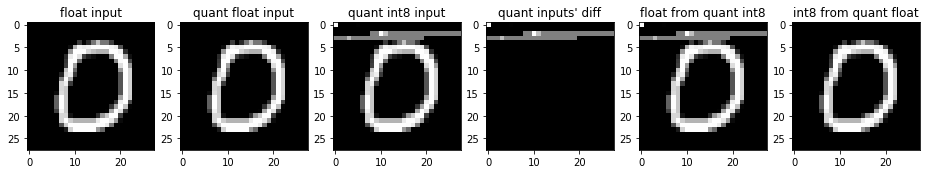

In [19]:
im_dict = {"float input": img_float,
           "quant float input": img_quant_float,
           "quant int8 input": img_quant_int8,
           "quant inputs' diff": img_quant_diff,
           "float from quant int8": img_quant_int8_float,
           "int8 from quant float": img_quant_float_int8}

plt.figure(figsize=(16,4))
for j, (title, im) in enumerate(im_dict.items()):
    plt.subplot(1, len(im_dict), j+1)
    kwargs = {'vmin':0, 'vmax':1} if title == "quant inputs' diff" else dict()
    plt.imshow(im, cmap='gray', **kwargs)
    plt.title(title)
plt.grid(False)
plt.show()

### Demonstrate that the bug corrupts the internal state

In [20]:
# TODO: file a bug report

interpreter_quant.set_tensor(interpreter_quant.get_input_details()[0]["index"], tf.expand_dims(img_quant_int8_float, 0))
interpreter_quant.invoke()
print('Output with corrupted image:')
print(interpreter_quant.get_tensor(interpreter_quant.get_output_details()[0]["index"]).flatten())

interpreter_quant.set_tensor(interpreter_quant.get_input_details()[0]["index"], tf.expand_dims(img_quant_float, 0))
interpreter_quant.invoke()
print('Output with uncorrupted image:')
print(interpreter_quant.get_tensor(interpreter_quant.get_output_details()[0]["index"]).flatten())

Output with corrupted image:
[0.00390625 0.         0.05859375 0.         0.         0.
 0.9375     0.         0.         0.        ]
Output with uncorrupted image:
[0.98828125 0.         0.         0.         0.         0.0078125
 0.         0.         0.         0.        ]


### Retrieve weights and quantizations, compare

In [21]:
weights_quant = interpreter_quant.get_tensor(3)
weights_float = interpreter_float.get_tensor(3)
weights_quantization = interpreter_quant.get_tensor_details()[3]['quantization']

weights_quant_diff = np.abs(np.float32(weights_quant) - weights_float / weights_quantization[0])
weights_rel_err = norm(weights_quant_diff) / norm(np.float32(weights_quant))
print('Mean relative error between quantized and float weights: {:.4%}'.format(weights_rel_err))

Mean relative error between quantized and float weights: 1.4318%


### Weight visualization

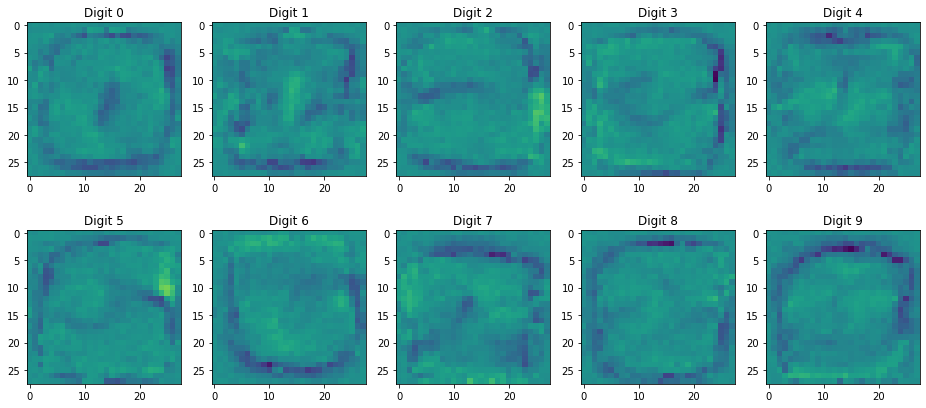

In [22]:
w = weights_quant.reshape(-1, 28, 28)
plt.figure(figsize=(16, 7))
for j in range(10):
    plt.subplot(2, 5, j+1)
    plt.imshow(w[j,:,:], vmin=-128, vmax=127)
    plt.title('Digit {}'.format(j))
plt.show()

### Distribution of weight quantization errors

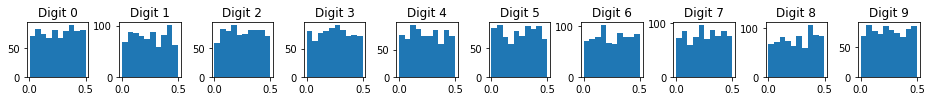

In [23]:
w = weights_quant_diff.reshape(-1, 28, 28)
plt.figure(figsize=(16, 1))
for j in range(10):
    plt.subplot(1, 10, j+1)
    plt.hist(w[j,:,:].reshape(-1))
    plt.title('Digit {}'.format(j))
plt.subplots_adjust(wspace=.5)
plt.show()

### Retrieve biases and quantizations, compare

In [24]:
bias_quant = interpreter_quant.get_tensor(4)
bias_float = interpreter_float.get_tensor(4)
bias_quantization = interpreter_quant.get_tensor_details()[4]['quantization']

bias_quant_diff = np.abs(np.float32(bias_quant) - bias_quantization[1] \
                                - bias_float / bias_quantization[0])
bias_rel_err = norm(bias_quant_diff) / norm(np.float32(bias_quant))
print('Mean relative error between quantized and float matmul bieses: {:.4%}'.format(bias_rel_err))

Mean relative error between quantized and float matmul bieses: 0.0030%


### Retrieve preactivations and quantizations, compare

In [25]:
# NOTE: the tensor dense/BiasAdd is actually a preactivation, not a bias
preact_quant = interpreter_quant.get_tensor(2)
preact_float = interpreter_float.get_tensor(2)
preact_quantization = interpreter_quant.get_tensor_details()[2]['quantization']

preact_quant_diff = np.abs(np.float32(preact_quant) - preact_quantization[1] - preact_float / preact_quantization[0])
preact_rel_err = norm(preact_quant_diff) / norm(np.float32(preact_quant))
print('Mean relative error between quantized and float preactivations: {:.4%}'.format(preact_rel_err))

Mean relative error between quantized and float preactivations: 0.7129%


### Retrieve outputs and quantizations, compare

In [26]:
output_float = interpreter_float.get_tensor(interpreter_float.get_output_details()[0]["index"])
output_quant_float = interpreter_quant.get_tensor(interpreter_quant.get_output_details()[0]["index"])
output_quant_int8 = interpreter_quant.get_tensor(0)
output_quantization = interpreter_quant.get_tensor_details()[0]['quantization']

output_quant_diff = np.abs(np.float32(output_quant_int8) - output_quantization[1] \
                     - output_float / output_quantization[0])
output_rel_err = norm(output_quant_diff) / norm(np.float32(output_quant_int8))
print('Mean relative error between quantized and float outputs: {:.4%}'.format(output_rel_err))

Mean relative error between quantized and float outputs: 0.1359%


# Interpreter reconstruction

In [27]:
# float interpreter
rec_preact_float = np.matmul(weights_float, img_float.flatten()) + bias_float
rec_out_float = tf.math.softmax(rec_preact_float).numpy()

with np.printoptions(formatter={'float': '{:.6e}'.format}):
    print("Reconstructed output:\n{}".format(rec_out_float))
    print("Original output:\n{}".format(output_float.flatten()))
    print("Relative error: {:.6e}".format(norm(rec_out_float-output_float.flatten())/norm(output_float.flatten())))

Reconstructed output:
[9.884325e-01 1.670280e-10 1.374182e-03 1.061891e-04 2.298280e-07
 8.574870e-03 7.232725e-05 4.620458e-09 1.438549e-03 1.260312e-06]
Original output:
[9.884323e-01 1.670283e-10 1.374182e-03 1.061891e-04 2.298278e-07
 8.574869e-03 7.232725e-05 4.620457e-09 1.438550e-03 1.260310e-06]
Relative error: 1.206043e-07


In [28]:
# int weights converted to float and float input (from quant model), compared quant output
rec_preact_float2 = np.matmul(
    np.float32(weights_quant)*weights_quantization[0],
    img_quant_float.flatten()
) + bias_quant*bias_quantization[0]

rec_out_float2 = tf.math.softmax(rec_preact_float2).numpy()
with np.printoptions(formatter={'float': '{:.6e}'.format}):
    print("Reconstructed output:\n{}".format(rec_out_float2))
    print("Original output:\n{}".format(output_float.flatten()))
    print("Relative error: {:.6e}".format(
        norm(rec_out_float2-output_float.flatten())/norm(output_float.flatten())))

Reconstructed output:
[9.885367e-01 1.820820e-10 1.374480e-03 1.092626e-04 2.332714e-07
 8.578900e-03 7.311835e-05 4.637166e-09 1.325920e-03 1.359527e-06]
Original output:
[9.884323e-01 1.670283e-10 1.374182e-03 1.061891e-04 2.298278e-07
 8.574869e-03 7.232725e-05 4.620457e-09 1.438550e-03 1.260310e-06]
Relative error: 1.554336e-04


In [29]:
# int weights converted to float and int input converted to float
# NOTE: because of the above bug, float->int8->float converted image is used
rec_preact_float3 = np.matmul(
    np.float32(weights_quant)*weights_quantization[0],
    (np.float32(img_quant_float_int8) - img_quantization[1]).flatten()*img_quantization[0]
) + bias_quant*bias_quantization[0]
rec_out_float3 = tf.math.softmax(rec_preact_float3).numpy()

with np.printoptions(formatter={'float': '{:.6e}'.format}):
    print("Reconstructed output:\n{}".format(rec_out_float3))
    print("Original output:\n{}".format(output_float.flatten()))
    print("Relative error: {:.6e}".format(
        norm(rec_out_float3-output_float.flatten())/norm(output_float.flatten())))

Reconstructed output:
[9.881978e-01 1.967770e-10 1.415560e-03 1.138298e-04 2.451321e-07
 8.838035e-03 7.575260e-05 4.963283e-09 1.357353e-03 1.423699e-06]
Original output:
[9.884323e-01 1.670283e-10 1.374182e-03 1.061891e-04 2.298278e-07
 8.574869e-03 7.232725e-05 4.620457e-09 1.438550e-03 1.260310e-06]
Relative error: 3.684538e-04


In [30]:
# int weights and int input, using 32 bit accumulation and 32 bit bias
rec_preact_int = np.matmul(np.int32(weights_quant),
                           np.int32(img_quant_float_int8).flatten()) \
    - np.matmul(np.int32(weights_quant),
                np.int32(img_quantization[1]*np.ones(img_quant_float_int8.size))) \
    + bias_quant
rec_out_int = tf.math.softmax(rec_preact_int*bias_quantization[0]).numpy()

with np.printoptions(formatter={'float': '{:.6e}'.format}):
    print("Reconstructed output:\n{}".format(rec_out_int))
    print("Original output:\n{}".format(output_float.flatten()))
    print("Relative error: {:.6e}".format(
        norm(rec_out_int-output_float.flatten())/norm(output_float.flatten())))

Reconstructed output:
[9.881978e-01 1.967772e-10 1.415561e-03 1.138299e-04 2.451323e-07
 8.838040e-03 7.575264e-05 4.963286e-09 1.357353e-03 1.423700e-06]
Original output:
[9.884323e-01 1.670283e-10 1.374182e-03 1.061891e-04 2.298278e-07
 8.574869e-03 7.232725e-05 4.620457e-09 1.438550e-03 1.260310e-06]
Relative error: 3.684613e-04


# XS3 emulation and scaling

In [31]:
# these are XS3 hardware parameters
bpv, bpe, vac = 256, 8, 8
ve = bpv//bpe

### Calculate int16 bias values for XS

In [32]:
# NOTE: on XS3 the accumulator for int8 vector operation is 2 x int8 (vR/vD), hence the int16 bias
# NOTE: to avoid saturation while computing the dot prod, the bias should be spread out between the elements
#       Thus vR/vD should be initialized with the spread out values in all elements
# TODO: there might be a better strategy to apply the bias
# TODO: storing the biases in int8 might be okay too, investigate
unified_bias = bias_quant - \
    np.matmul(np.int32(weights_quant),
              np.int32(img_quantization[1]*np.ones(img_quant_float_int8.size)))
unified_bias = unified_bias / np.float32(2**(bpe-2))  # the shift here is b/c of how VLMACCR works
unified_bias_int16_ve = np.round(unified_bias / ve)  # spread out the bias between vR/vD elements
unified_bias_int16_ve = np.int16(np.clip(unified_bias_int16_ve, -2**(2*bpe-1), 2**(2*bpe-1)-1))

print("These are int16 bias values that the XS3 implementation should store:")
print(unified_bias_int16_ve)

These are int16 bias values that the XS3 implementation should store:
[-417 -457 -191 -242 -495 -199 -326 -321 -415 -522]


### Define functions that emulate vector unit on XS

In [33]:
# NOTE: vacc is equivalent to the vR/vD pair in XS3

def VLMACCR(a, b, vacc):
    assert len(a) == len(b) == len(vacc)
    t = np.round(np.int16(a)*np.int16(b) / np.float32(2**(bpe-2)))  # multiply, round+shift
    t = sum(t) + np.float32(vacc[-1])  # sum and apply bias from buffer
    t = np.clip(t, -2**(bpe+vac-1)+1, 2**(bpe+vac-1)-1)  # this is how VLMACCR saturates in XS3
    vacc = np.hstack([np.int16(t), vacc[:-1]])  # update buffer
    return vacc

def VLSAT(v, s=0):
    t = np.round(np.float32(v) / 2**s)
    t = np.clip(t, -2**(bpe-1), 2**(bpe-1)-1)
    return np.int8(t)

def VLREDSUM(v, s=0):  # this actually doesn't exists in the XS3 ISA (yet?)
    vacc = np.zeros(ve, dtype=np.int16)
    # use VLMACCR to do the summation, so we need a 2**(bpe-2) shift
    vacc = VLMACCR(v, np.int8(np.ones(v.shape) * 2**(bpe-2-s)), vacc)
    return vacc

In [34]:
from math import ceil

def XS3_dot_prod(v, w, bias_vacc=None, scale1=4, scale2=1):
    assert len(v) == len(w)
    num_vlmaccr = ceil(len(v)/ve)  # this is a trick
    
    # add bias (distributed accross all elements of vacc)
    if bias_vacc is None:
        vacc = np.zeros(ve, dtype=np.int16)
    else:
        vacc = bias_vacc
    
    pad = num_vlmaccr * ve - len(v)
    v, w = np.pad(v, (0, pad)), np.pad(w, (0, pad))
    for n in range(num_vlmaccr):
        beg, end = n*ve, (n+1)*ve
        vacc = VLMACCR(v[beg:end], w[beg:end], vacc)

    # saturate vector register contents
    # NOTE: the shift here is our choice, maybe optimize for it?
    # if this shift is too small, saturation will occure often
    # if it's too large, we loose less significant digits, which also leads to loss in accuracy
    vR = VLSAT(vacc, scale1)
    
    # sum contents of vector register
    # result is int16 value stored at the beginning of vR/vD
    # NOTE: the shift here is our choice, maybe optimize for it?
    
    # use this for more accuracy
    vacc = VLREDSUM(vR)
    vR = VLSAT(vacc, scale2)
    
    # less accurate but one less instruction
    #vR = np.int8(VLREDSUM(vR, scale2))

    return vR[0]  # result is int8

# TODO: there is probably a more efficient way to do matrix-vector multiplication
def XS3_fcc_forward(input_int8, weights_int8, bias_int16_ve,
                    scale1, scale2):
    bias_int16_vacc = np.tile(bias_int16_ve, (ve, 1)).T  # just a copy for easy access
    output_int8 = np.zeros(weights_quant.shape[0], dtype=np.int8)
    for feature_num in range(10):
        w = weights_int8[feature_num]  # these are the feature coeffs
        bias_vacc = bias_int16_vacc[feature_num]
        output_int8[feature_num] = XS3_dot_prod(w, input_int8, bias_vacc,
                                                scale1, scale2)

    return output_int8

### Calculate preactivation on xs3, compare

If the only goal is classification, getting the argmax of the preactivation is sufficient.

In [35]:
scale1, scale2 = 4, 1  # TODO: find these scales by optimization on the training set
preact_xs3 = XS3_fcc_forward(input_int8=img_quant_float_int8.flatten(),
                             weights_int8=weights_quant, bias_int16_ve=unified_bias_int16_ve,
                             scale1=scale1, scale2=scale2)
print("int8 preactivation values produced by XS3 emulation:")
print(preact_xs3)
print("int8 preactivation values produced by int32 accumulation:")
print(np.int8(np.round(rec_preact_int / np.float32(2**(bpe-2)) / 2**(scale1+scale2))))

int8 preactivation values produced by XS3 emulation:
[  40 -103   -4  -18  -58   10  -20  -80   -6  -48]
int8 preactivation values produced by int32 accumulation:
[  39 -102   -2  -18  -57   10  -20  -81   -2  -46]


In [36]:
# compare to float preactivation
rec_preact_xs3 = preact_xs3 * np.float32(2**(bpe-2)) * 2**(scale1+scale2) * bias_quantization[0]

with np.printoptions(formatter={'float': '{:.6e}'.format}):
    print("Reconstructed preactivation (xs3):\n{}".format(rec_preact_xs3))
    print("Original preactivation:\n{}".format(preact_float.flatten()))
    print("Relative error: {:.6e}".format(
        norm(rec_preact_xs3-preact_float.flatten())/norm(preact_float.flatten())))

Reconstructed preactivation (xs3):
[6.323052e+00 -1.628186e+01 -6.323052e-01 -2.845373e+00 -9.168426e+00
 1.580763e+00 -3.161526e+00 -1.264610e+01 -9.484578e-01 -7.587663e+00]
Original preactivation:
[6.304264e+00 -1.619696e+01 -2.739979e-01 -2.834390e+00 -8.970037e+00
 1.556980e+00 -3.218410e+00 -1.287687e+01 -2.282205e-01 -7.268253e+00]
Relative error: 3.703357e-02


### Evaluate performance of the XS3 emulation

In [37]:
# this takes a while because the XS3 emulation is very inefficient
predictions_xs3 = np.zeros(predictions.shape, dtype=np.int64)
for j, im in enumerate(test_images):  #.shape, img_quant_float_int8.shape
    preact_xs3 = XS3_fcc_forward(input_int8=np.int8(im+img_quantization[1]).flatten(),
                                 weights_int8=weights_quant, bias_int16_ve=unified_bias_int16_ve,
                                 scale1=scale1, scale2=scale2)
    predictions_xs3[j] = np.argmax(preact_xs3)
    if (j+1) % 10 == 0:
        print('{:6d}/10000'.format(j+1), end='\r')
print()

 10000/10000


In [38]:
acc = tf.metrics.Accuracy()
print('Accuracy of models:')
print('# Original keras model:   {:.2%}'.format(acc(test_labels, predictions).numpy()))
print('# Float TFLite model:     {:.2%}'.format(acc(test_labels, predictions_float).numpy()))
print('# Quantized TFLite model: {:.2%}'.format(acc(test_labels, predictions_quant).numpy()))
print('# Emulated XS3 model:     {:.2%}'.format(acc(test_labels, predictions_xs3).numpy()))

Accuracy of models:
# Original keras model:   92.67%
# Float TFLite model:     92.67%
# Quantized TFLite model: 92.63%
# Emulated XS3 model:     92.52%
